<a href="https://colab.research.google.com/github/joe-granick/CS439/blob/main/data_ingest10K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libries

In [ ]:
!pip install sec_edgar_downloader

In [ ]:
from sec_edgar_downloader import Downloader
from bs4 import BeautifulSoup
import glob, os, re, pprint, json

# configure downloader

In [42]:
USER  = "Joe Granick (jmgranick@gmail.com)"
EMAIL = "jmgranick@gmail.com"
DIR = "/mnt/data/10k_filings"
TICKERS = ["AAPL", "MSFT", "GOOGL"]
FILING_YEARS = 2
FILING_TYPE = "10-K"


dl = Downloader(USER, EMAIL, DIR)
for ticker in TICKERS:
  # creates folder for each filing
  dl.get(FILING_TYPE, ticker,limit=FILING_YEARS, download_details=True)

# Read in Text Corpus From Folder

In [57]:
import glob, os, re
from bs4 import BeautifulSoup
from collections import Counter
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt

# 1) Find the filings
DOWNLOAD_DIR = "10k_filings"
pattern = os.path.join(DOWNLOAD_DIR, "sec-edgar-filings", "*", "10-K", "*", "full-submission.txt")
paths = glob.glob(pattern)
print(f"Found {len(paths)} filings")

# 2) Extract & clean MD&A for each
docs = {}
for full in paths:
    raw = open(full, "r", encoding="utf-8").read()
    # Turn into plain text
    text = BeautifulSoup(raw, "html.parser").get_text("\n")
    text = text.replace("’", "'")  # normalize quotes

    # (A) Split off at the end of MD&A
    md_parts = re.split(r"(?i)Item\s+7A\.|Item\s+8\.", text)
    md_section = md_parts[0]

    # (B) Remove the MD&A heading itself
    md_clean = re.sub(
        r"(?i)Item\s+7\.?\s*Management's Discussion and Analysis(?: of Financial Condition and Results of Operations)?",
        "",
        md_section
    ).strip()

    # Year from FILED AS OF
    mdate = re.search(r"FILED AS OF DATE:\s*(\d{8})", raw)
    year = mdate.group(1)[:4] if mdate else "unknown"

    ticker = full.split(os.sep)[-4]
    docs[f"{ticker}_{year}"] = md_clean

print("Loaded docs:", list(docs.keys()))

# 3) Tokenize & term‐frequency
stop = set(ENGLISH_STOP_WORDS)
def tokenize(s):
    s = re.sub(r'[^a-z\s]',' ', s.lower())
    return [w for w in s.split() if w not in stop and len(w)>2]

all_toks = [tok for d in docs.values() for tok in tokenize(d)]
freq = Counter(all_toks)
df_freq = pd.DataFrame(freq.most_common(20), columns=["term","frequency"])
print(df_freq)

# 4) TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r'(?u)\b[a-zA-Z]{3,}\b')
tfidf = vectorizer.fit_transform(docs.values())
feat = vectorizer.get_feature_names_out()

rows = []
for i,(key,_) in enumerate(docs.items()):
    scores = tfidf[i].toarray().flatten()
    for idx in scores.argsort()[::-1][:5]:
        rows.append({"doc":key, "term":feat[idx], "score":scores[idx]})
df_tfidf = pd.DataFrame(rows)
print(df_tfidf)


Found 6 filings
Loaded docs: ['AAPL_2023', 'AAPL_2024', 'MSFT_2023', 'MSFT_2024', 'GOOGL_2024', 'GOOGL_2025']
                               term  frequency
0                              gaap       1994
1                              msft        398
2                              goog        287
3                              aapl        184
4                            member        182
5              fairvalueinputslevel        161
6                               srt        157
7     foreignexchangecontractmember        154
8                              http        106
9                              fasb        106
10                              org        106
11                       registrant        106
12                              act         84
13  nonoperatingincomeexpensemember         84
14              nondesignatedmember         79
15                          company         70
16                    maximummember         69
17                    minimummember         

# Text Processing

In [49]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

custom_stop = {"financial","condition","results","operations"}
all_stop = set(ENGLISH_STOP_WORDS) | custom_stop

def tokenize(text):
    t = text.lower()
    t = re.sub(r'[^a-z\s]', ' ', t)
    toks = t.split()
    return [w for w in toks if w not in all_stop and len(w)>2]

In [50]:
from collections import Counter
all_tokens = []
for body in docs.values():
    all_tokens += tokenize(body)

freq = Counter(all_tokens)
top20 = freq.most_common(20)


,term,frequency


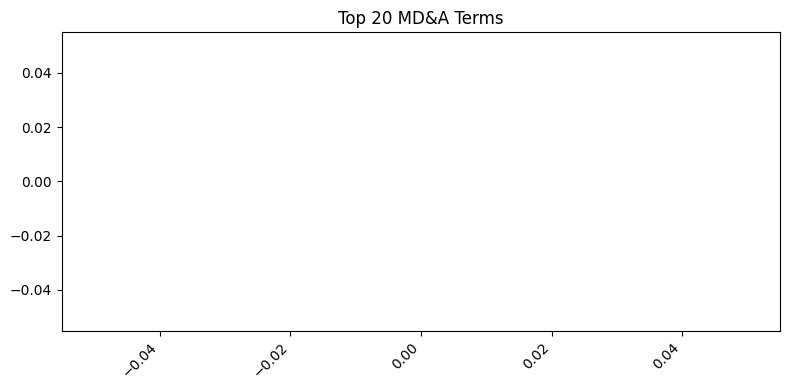

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

df_freq = pd.DataFrame(top20, columns=["term","frequency"])
display(df_freq)   # or use ace_tools.display_dataframe_to_user

# Bar chart
plt.figure(figsize=(8,4))
plt.bar(df_freq["term"], df_freq["frequency"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 MD&A Terms")
plt.tight_layout()
plt.show()


In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    stop_words="english",
    token_pattern=r"(?u)\b[a-zA-Z]{3,}\b"
)
tfidf_mat = vectorizer.fit_transform(docs.values())
features = vectorizer.get_feature_names_out()


In [55]:
rows = []
for i, key in enumerate(docs.keys()):
    scores = tfidf_mat[i].toarray().flatten()
    top5 = scores.argsort()[::-1][:5]
    for idx in top5:
        rows.append({
            "document": key,
            "term": features[idx],
            "score": scores[idx]
        })
df_tfidf = pd.DataFrame(rows)
display(df_tfidf)


,document,term,score
0,AAPL_2023,results,0.5
1,AAPL_2023,operations,0.5
2,AAPL_2023,financial,0.5
3,AAPL_2023,condition,0.5
4,AAPL_2024,results,0.5
5,AAPL_2024,operations,0.5
6,AAPL_2024,financial,0.5
7,AAPL_2024,condition,0.5
8,MSFT_2023,results,0.5
9,MSFT_2023,operations,0.5


In [52]:
import os
print("Working dir:", os.getcwd())
print("Contents:", os.listdir())

Working dir: /content
Contents: ['.config', '10k_filings', 'sample_data']


In [53]:
!ls -R 10k_filings

10k_filings:
sec-edgar-filings

10k_filings/sec-edgar-filings:
AAPL  GOOGL  MSFT

10k_filings/sec-edgar-filings/AAPL:
10-K

10k_filings/sec-edgar-filings/AAPL/10-K:
0000320193-23-000106  0000320193-24-000123

10k_filings/sec-edgar-filings/AAPL/10-K/0000320193-23-000106:
full-submission.txt  primary-document.html

10k_filings/sec-edgar-filings/AAPL/10-K/0000320193-24-000123:
full-submission.txt  primary-document.html

10k_filings/sec-edgar-filings/GOOGL:
10-K

10k_filings/sec-edgar-filings/GOOGL/10-K:
0001652044-24-000022  0001652044-25-000014

10k_filings/sec-edgar-filings/GOOGL/10-K/0001652044-24-000022:
full-submission.txt  primary-document.html

10k_filings/sec-edgar-filings/GOOGL/10-K/0001652044-25-000014:
full-submission.txt  primary-document.html

10k_filings/sec-edgar-filings/MSFT:
10-K

10k_filings/sec-edgar-filings/MSFT/10-K:
0000950170-23-035122  0000950170-24-087843

10k_filings/sec-edgar-filings/MSFT/10-K/0000950170-23-035122:
full-submission.txt  primary-document.html

10k

In [40]:
import glob, os, re
from bs4 import BeautifulSoup

DOWNLOAD_DIR = "10k_filings"
pattern = os.path.join(DOWNLOAD_DIR,
                       "sec-edgar-filings",
                       "*", "10-K", "*", "full-submission.txt")

paths = glob.glob(pattern)
print(f"Found {len(paths)} filings:\n", paths, "\n")

docs = {}
for path in paths:
    # read raw
    raw = open(path, "r", encoding="utf-8").read()

    # extract MD&A with a more robust boundary: Item 7 … up to Item 7A or Item 8
    text = BeautifulSoup(raw, "html.parser").get_text("\n")
    # normalize curly quotes to straight so regex is simpler
    text = text.replace("’", "'")
    # split out by Items
    m = re.search(
        r"(?:Item\s+7[A]?\.\s*Management's Discussion and Analysis)(.*?)(?=(?:Item\s+7A\.|Item\s+8\.))",
        text,
        flags=re.S|re.I
    )
    body = m.group(1).strip() if m else "<no MD&A found>"

    # show a preview
    print(os.path.basename(os.path.dirname(path)), "→", body[:200].replace("\n"," "), "…\n")

    # stash it
    ticker = path.split(os.sep)[-4]
    # get real year from FILED AS OF
    yy = re.search(r"FILED AS OF DATE:\s*(\d{8})", raw)
    year = yy.group(1)[:4] if yy else "unknown"
    docs[f"{ticker}_{year}"] = body

print("Final docs keys:", list(docs.keys()))


Found 6 filings:
 ['10k_filings/sec-edgar-filings/AAPL/10-K/0000320193-23-000106/full-submission.txt', '10k_filings/sec-edgar-filings/AAPL/10-K/0000320193-24-000123/full-submission.txt', '10k_filings/sec-edgar-filings/MSFT/10-K/0000950170-23-035122/full-submission.txt', '10k_filings/sec-edgar-filings/MSFT/10-K/0000950170-24-087843/full-submission.txt', '10k_filings/sec-edgar-filings/GOOGL/10-K/0001652044-24-000022/full-submission.txt', '10k_filings/sec-edgar-filings/GOOGL/10-K/0001652044-25-000014/full-submission.txt'] 

0000320193-23-000106 → of Financial Condition and Results of Operations 20 …

0000320193-24-000123 → of Financial Condition and Results of Operations 21 …

0000950170-23-035122 → of Financial Condition and Results of Operations       40 …

0000950170-24-087843 → of Financial Condition and Results of Operations       39 …

0001652044-24-000022 → of Financial Condition and Results of Operations 29 …

0001652044-25-000014 → of Financial Condition and Results of Operations